<a href="https://colab.research.google.com/github/devparikh0506/DATA-603/blob/main/assignment-3/DATA_603_Chicago_Crime_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Following code to install spark in google colab refered from here : https://colab.research.google.com/drive/1fa2G3YuXx3Isqyby5kFETqmWotFwtqlH?usp=sharing
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType, BooleanType

spark_session = SparkSession.builder.appName("ChicagoCrimeEDA").getOrCreate()
sc = spark_session.sparkContext

spark_session

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as 

Defining schema

In [ ]:
# For this data I'll define string types for numeric columns as well.
# Because the API i am using to get the JSON data is giving string values for all numeric columns.
# Later I will convert necessary columns to appropriate types

schema = StructType([
    StructField("id", StringType(), True),
    StructField("case_number", StringType(), True),
    StructField("date", StringType(), True),
    StructField("block", StringType(), True),
    StructField("iucr", StringType(), True),
    StructField("primary_type", StringType(), True),
    StructField("description", StringType(), True),
    StructField("location_description", StringType(), True),
    StructField("arrest", BooleanType(), True),
    StructField("domestic", BooleanType(), True),
    StructField("beat", StringType(), True),
    StructField("district", StringType(), True),
    StructField("ward", StringType(), True),
    StructField("community_area", StringType(), True),
    StructField("fbi_code", StringType(), True),
    StructField("x_coordinate", StringType(), True),
    StructField("y_coordinate", StringType(), True),
    StructField("year", StringType(), True),
    StructField("updated_on", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("location", StringType(), True)
])

### Loading data

For this project I will load data using SODA API which is mentioned by the data source itself.

Reference : https://dev.socrata.com/foundry/data.cityofchicago.org/ijzp-q8t2

In [ ]:
!pip install sodapy

In [ ]:
from sodapy import Socrata
import datetime

Since the data too large and with SODA API we can request only limited data at once I will load data for each year separately.

The logic is :
- First initialize client
- Start looping over the years till 2001 starting from current year
- For each year first load 500000 entries using request and if the data count is less than 500000 then load other 500000 entries and continue this loop until we get data size less than 500000. **Note: We can change the limit 500000 to any number.**
- Then store the data of each year into separate csv file using pandas under same directory
- Finally load data inside target directory using pyspark and return the dataframe

In [132]:
column_order = [
    "id",
    "case_number",
    "date",
    "block",
    "iucr",
    "primary_type",
    "description",
    "location_description",
    "arrest",
    "domestic",
    "beat",
    "district",
    "ward",
    "community_area",
    "fbi_code",
    "x_coordinate",
    "y_coordinate",
    "year",
    "updated_on",
    "latitude",
    "longitude",
    "location"
]

In [139]:
from pathlib import Path
import pandas as pd
import os

def load_chicago_crime_data_for_year(year : int , client , offset=0, limit=500_000):
  """
  Loads Chicago crime data for a given year.
  """
  try:
    results = client.get("ijzp-q8t2", limit=limit, offset=offset, year=year)
    if not (len(results) < limit):
      results += load_chicago_crime_data_for_year(year, client, offset=offset + limit, limit=limit)
    return results
  except Exception as e:
    print(f"Error loading data for year({year}):\n{e}")
    return []

def load_chicago_crime_data(limit=None):
  """
  Loads Chicago crime data.
  If limit is provided, it will load only that many rows.
  If limit is not provided, it will load all rows.
  """
  client = Socrata("data.cityofchicago.org", None)
  years = range(datetime.datetime.now().year, 2000, -1)
  loaded_data_count=0
  dir = './data'
  Path(dir).mkdir(parents=True, exist_ok=True)
  for year in years:
      filename = f"{dir}/data_{year}.csv"
      if os.path.isfile(filename) :
        print(f"File already exists for year : {year}")
        continue
      print(f"Loading data for year : {year}")
      data = load_chicago_crime_data_for_year(year, client)
      temp_pd_df = pd.DataFrame(data)[column_order]

      #saving year data into csv
      temp_pd_df.to_csv(filename, index=False)
      #saving year data into csv
      temp_df_count = len(data)
      loaded_data_count += temp_df_count
      if limit and loaded_data_count >= limit:
          break
      print(f"Successfully loaded data for year({year}) =========> Data size : {temp_df_count}(rows)")
  df = spark_session.read.csv(dir, header=True, schema=schema)
  print(f"Successfully loaded all data")
  return df

crime_df = load_chicago_crime_data()

Loading data for year : 2024
Successfully loaded data for year(2024) =========> Data size : 209572(rows)
Loading data for year : 2023
Successfully loaded data for year(2023) =========> Data size : 262599(rows)
Loading data for year : 2022
Successfully loaded data for year(2022) =========> Data size : 239569(rows)
Loading data for year : 2021
Successfully loaded data for year(2021) =========> Data size : 209362(rows)
Loading data for year : 2020
Successfully loaded data for year(2020) =========> Data size : 212498(rows)
Loading data for year : 2019
Successfully loaded data for year(2019) =========> Data size : 261519(rows)
Loading data for year : 2018
Successfully loaded data for year(2018) =========> Data size : 269051(rows)
Loading data for year : 2017
Successfully loaded data for year(2017) =========> Data size : 269201(rows)
Loading data for year : 2016
Successfully loaded data for year(2016) =========> Data size : 269921(rows)
Loading data for year : 2015
Successfully loaded data f

Let's verify the loaded data count

In [140]:
crime_df.count()

8187778

### Data cleaning

Removing null values

In [141]:
def print_null_report(df):
    print(df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show())

In [142]:
print_null_report(crime_df)

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| id|case_number|date|block|iucr|primary_type|description|location_description|arrest|domestic|beat|district|  ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on|latitude|longitude|location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|               13677|     0|       0|   0|      47|614830|        613454|       0|       90056|       90056|   0|         0|   90056|    90056|   90056|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

In [143]:
crime_df = crime_df.na.drop("any")

In [146]:
print_null_report(crime_df)

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| id|case_number|date|block|iucr|primary_type|description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on|latitude|longitude|location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

Converting columns to appropriate types

Especially converting date column to timestamp

In [147]:
crime_df = crime_df.withColumn("date", to_timestamp("date"))
crime_df = crime_df.withColumn("updated_on", to_timestamp("updated_on"))
crime_df = crime_df.withColumn("arrest", col("arrest").cast(BooleanType()))
crime_df = crime_df.withColumn("domestic", col("domestic").cast(BooleanType()))
crime_df = crime_df.withColumn("ward", col("ward").cast(IntegerType()))
crime_df = crime_df.withColumn("community_area", col("community_area").cast(IntegerType()))
crime_df = crime_df.withColumn("x_coordinate", col("x_coordinate").cast(DoubleType()))
crime_df = crime_df.withColumn("y_coordinate", col("y_coordinate").cast(DoubleType()))
crime_df = crime_df.withColumn("year", col("year").cast(IntegerType()))
crime_df = crime_df.withColumn("latitude", col("latitude").cast(DoubleType()))
crime_df = crime_df.withColumn("longitude", col("longitude").cast(DoubleType()))

In [148]:
crime_df.show(n=5)

+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|     id|case_number|               date|               block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|
+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|4215042|   HL525347|2002-06-01 00:00:00| 091XX S BUFFALO AVE|0840|               THEFT|FINANCIAL ID THEF...|           RESIDENCE| fa

Filtering data for last ten years

In [149]:
crime_df_recent_ten_yrs = crime_df.filter(year(col("date")) >= year(current_date()) - 10)

Removing followin crime types

- 'NON-CRIMINAL (SUBJECT SPECIFIED)'
- 'OTHER OFFENSE'
- 'STALKING'
- 'NON - CRIMINAL'
- 'ARSON'

In [150]:
crime_df_recent_ten_yrs.select("primary_type").distinct().show(100, False)

+---------------------------------+
|primary_type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|STALKING                         |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|ARSON                            |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|NON - CRIMINAL                   |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                

In [151]:
excluded_crime_types = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON-CRIMINAL', 'NON - CRIMINAL', 'ARSON']
crime_df_filtered = crime_df_recent_ten_yrs.filter(~col("primary_type").isin(excluded_crime_types))

In [152]:
crime_df_filtered.select("primary_type").distinct().show(100, False)

+---------------------------------+
|primary_type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|NON - CRIMINAL                   |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|KIDNAPPING                 

Merging similar crime types into one crime

In [153]:
similar_crime_types = {
    "SEXUAL CRIME" : ['CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE', 'PROSTITUTION'],
    "DRUG  CRIME" : ['NARCOTICS', 'OTHER NARCOTIC VIOLATION'],
    "THEFT AND FRAUD" : ["MOTOR VEHICLE THEFT", "THEFT", "DECEPTIVE PRACTICE"],
    "WEAPONS AND INTIMIDATION" : ["INTIMIDATION", "CONCEALED CARRY LICENSE VIOLATION", "WEAPONS VIOLATION", "INTERFERENCE WITH PUBLIC OFFICER"],
    "PUBLIC ORDER CRIME" : ["PUBLIC PEACE VIOLATION", "OBSCENITY", "GAMBLING", "LIQUOR LAW VIOLATION"]
}

for new_crime_type, old_crime_types in similar_crime_types.items():
    crime_df_filtered = crime_df_filtered.withColumn("primary_type", when(col("primary_type").isin(old_crime_types), new_crime_type).otherwise(col("primary_type")))

crime_df_filtered.select("primary_type").distinct().show(100, False)

+--------------------------+
|primary_type              |
+--------------------------+
|SEXUAL CRIME              |
|OFFENSE INVOLVING CHILDREN|
|PUBLIC ORDER CRIME        |
|CRIMINAL TRESPASS         |
|ASSAULT                   |
|NON - CRIMINAL            |
|DRUG  CRIME               |
|BATTERY                   |
|THEFT AND FRAUD           |
|ROBBERY                   |
|HOMICIDE                  |
|PUBLIC INDECENCY          |
|CRIM SEXUAL ASSAULT       |
|HUMAN TRAFFICKING         |
|WEAPONS AND INTIMIDATION  |
|CRIMINAL DAMAGE           |
|KIDNAPPING                |
|BURGLARY                  |
|RITUALISM                 |
+--------------------------+



### Data analysis

#### Year-wise trend of the crime

In [154]:
from matplotlib import pyplot as plt

In [155]:
year_trend = crime_df_filtered.groupBy("Year").count().orderBy("Year")
year_trend.show()

+----+------+
|Year| count|
+----+------+
|2014|256121|
|2015|239903|
|2016|248555|
|2017|246533|
|2018|245354|
|2019|240851|
|2020|193869|
|2021|187548|
|2022|219012|
|2023|243892|
|2024|194139|
+----+------+



##### Plotting line plot for a better view of trend

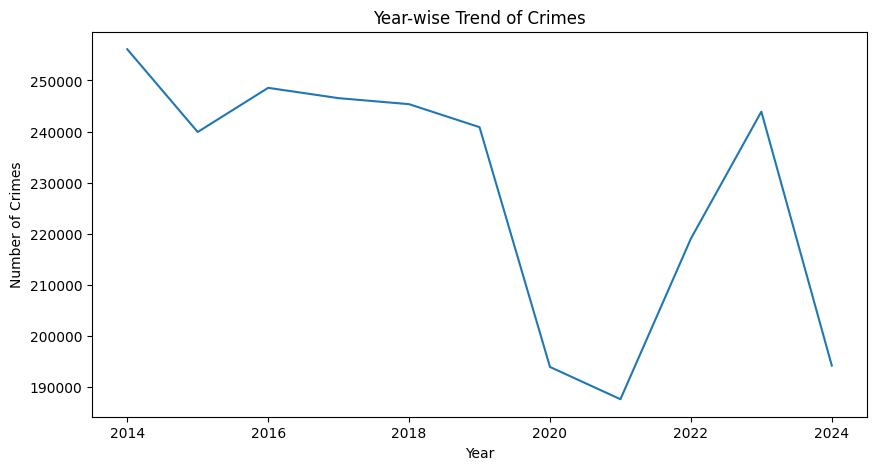

In [156]:
plt.figure(figsize=(10, 5))
year_trend_df = year_trend.toPandas()
plt.plot(year_trend_df['Year'], year_trend_df['count'])
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Year-wise Trend of Crimes")
plt.show()

#### Let's find which hour of the day crime is highest

In [157]:
hourly_crime = crime_df_filtered.withColumn("Hour", hour("Date")).groupBy("Hour").count().orderBy(desc("count"))
print(hourly_crime.show(1))
print(f"Highest crime hour is : {hourly_crime.first()['Hour']}")

+----+------+
|Hour| count|
+----+------+
|  12|144989|
+----+------+
only showing top 1 row

None
Highest crime hour is : 12


#### Lets plot top ten crimes into a bar chart

In [158]:
crime_df_top_ten = crime_df_filtered.groupBy("primary_type").count().orderBy(desc("count")).limit(10)
crime_df_top_ten.show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|     THEFT AND FRAUD|928099|
|             BATTERY|500988|
|     CRIMINAL DAMAGE|300406|
|             ASSAULT|213884|
|         DRUG  CRIME|128392|
|            BURGLARY|113001|
|             ROBBERY|104077|
|WEAPONS AND INTIM...| 80922|
|   CRIMINAL TRESPASS| 61075|
|        SEXUAL CRIME| 26553|
+--------------------+------+



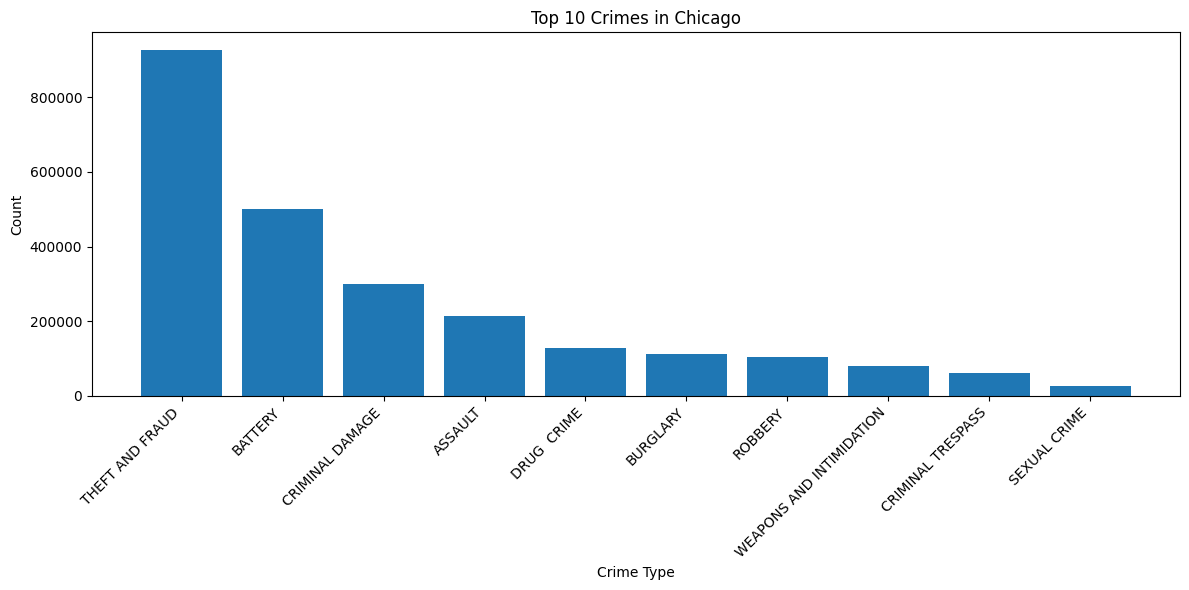

In [159]:
crime_df_top_ten_pd  = crime_df_top_ten.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(crime_df_top_ten_pd["primary_type"], crime_df_top_ten_pd["count"])
plt.title("Top 10 Crimes in Chicago")
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()